# Example: Obtaining Market Aggregates Through the Jua SDK

First of all, make sure your Jua API key ID and API key secrets are set as environment variables. If they aren't, you can set them with (before imporing `jua`!):

In [ ]:
import os

os.environ["JUA_API_KEY_ID"] = "YOUR_API_KEY_ID"
os.environ["JUA_API_KEY_SECRET"] = "YOUR_API_KEY_SECRET"

## Imports

In [2]:
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from jua import JuaClient
from jua.market_aggregates import AggregateVariables, ModelRuns
from jua.types import MarketZones
from jua.weather import Models

## Create a Client

In [3]:
client = JuaClient()

## Examples


### Obtaining Market Aggregates for Germany

First, we can create the `EnergyMarket` for which we want to query aggregates.

In [4]:
market_de = client.market_aggregates.get_market(MarketZones.DE)
market_de

<EnergyMarket zones=['DE']>

Then, we can query the market for any of the available `AggregateVariables`.

In [5]:
for av in AggregateVariables:
    print(av.name)

AIR_TEMPERATURE_AT_HEIGHT_LEVEL_2M
SURFACE_DOWNWELLING_SHORTWAVE_FLUX_SUM_1H
WIND_SPEED_AT_HEIGHT_LEVEL_10M
WIND_SPEED_AT_HEIGHT_LEVEL_100M


Let's get market aggregates for 100m wind speed, for the 2 latest runs of EPT-2, EPT-1.5 and ECMWF IFS.

In [6]:
# Select the model runs - here using the latest 2 runs for EPT 2, EPT 1.5 and ECMWF IFS
model_runs = [
    ModelRuns(Models.EPT2, [0, 1]),
    ModelRuns(Models.EPT1_5, [0, 1]),
    ModelRuns(Models.ECMWF_IFS_SINGLE, [0, 1]),
]

# Get the market aggregates for the next 8 days
ds_aggregates = market_de.compare_runs(
    agg_variable=AggregateVariables.WIND_SPEED_AT_HEIGHT_LEVEL_100M,
    model_runs=model_runs,
    max_lead_time=8 * 24,
)

print("Returned Dataset:")
ds_aggregates

Returned Dataset:


<xarray.Dataset> Size: 21kB
Dimensions:                          (model_run: 6, time: 199)
Coordinates:
  * model_run                        (model_run) object 48B 'ecmwf_ifs_single...
  * time                             (time) datetime64[ns, UTC] 2kB 2025-10-0...
    model                            (model_run) object 48B 'ecmwf_ifs_single...
    init_time                        (model_run) datetime64[ns] 48B 2025-10-0...
Data variables:
    prediction_timedelta             (model_run, time) float64 10kB 0.0 ... 1...
    wind_speed_at_height_level_100m  (model_run, time) float64 10kB 5.975 ......
Attributes:
    var_name:          wind_speed_at_height_level_100m
    var_display_name:  Wind Speed At Height Level 100m
    unit:              m s⁻¹
    weighting:         wind_capacity
    market_zone:       ['DE']
    min_lead_time:     0
    max_lead_time:     192

### Visualizing Market Aggregates

We can then visualize the predictions from the different model runs.

We filter out missing values for the different runs before plotting. The `time` dimension is common for all models, but not all models have the same temporal resolution (some will have values every hour, some every 6 hours). We'll make a helper function to visualize results.


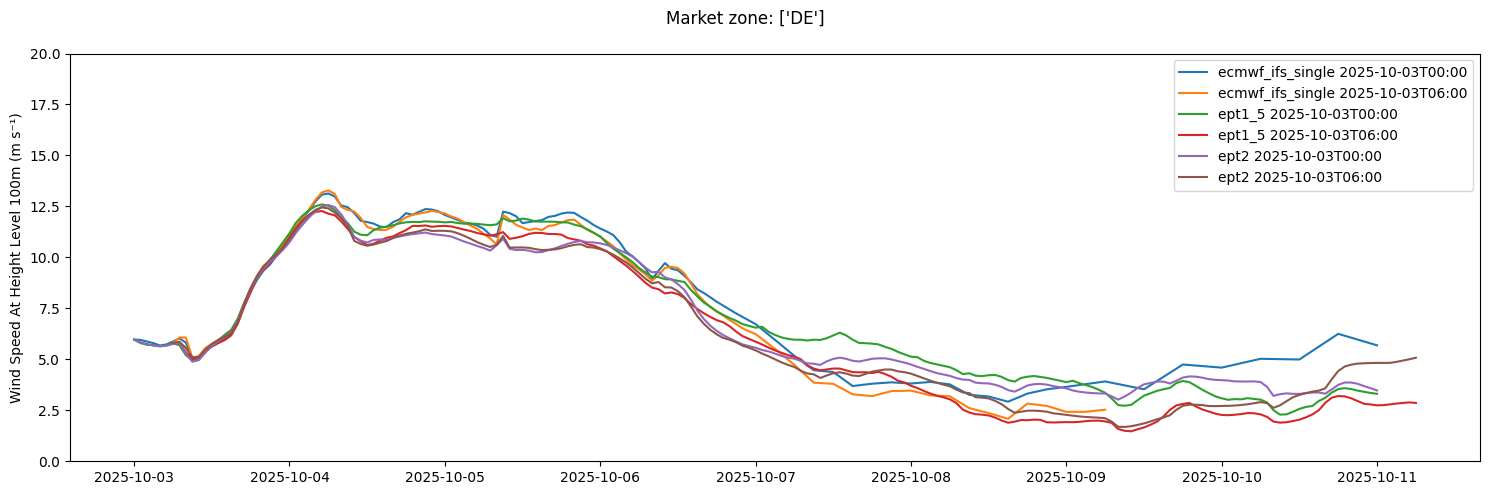

In [7]:
def plot_market_aggregates(
    ds: xr.Dataset,
    ylim: tuple[int, int] | None = None,
    figsize: tuple[int, int] = (15, 5),
):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    fig.suptitle(f"Market zone: {ds.market_zone}")
    ax.set_ylabel(f"{ds.var_display_name} ({ds.unit})")
    if ylim is not None:
        ax.set_ylim(*ylim)

    for i, m in enumerate(ds.model_run.values):
        da = ds.isel(model_run=i)[ds.var_name]
        x = da.time
        y = da.values

        valid_values = ~np.isnan(y)
        ax.plot(x[valid_values], y[valid_values], label=m)

    plt.legend()
    plt.tight_layout()
    plt.show()


plot_market_aggregates(ds_aggregates, ylim=(0, 20))

We can also use the `init_time` and `model` coordinates to select which models we want to visualize:

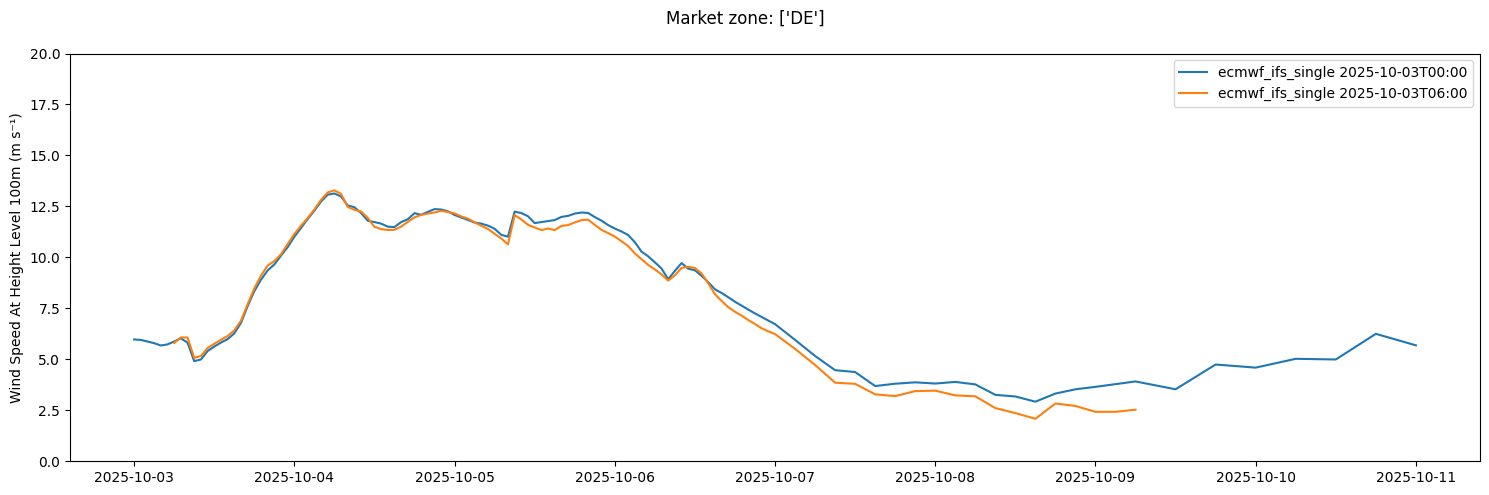

In [8]:
# Only keep runs for ECMWF_IFS_SINGLE
ds_aggregates_ifs = ds_aggregates.where(
    ds_aggregates.model == Models.ECMWF_IFS_SINGLE.value, drop=True
)

plot_market_aggregates(ds_aggregates_ifs, ylim=(0, 20))

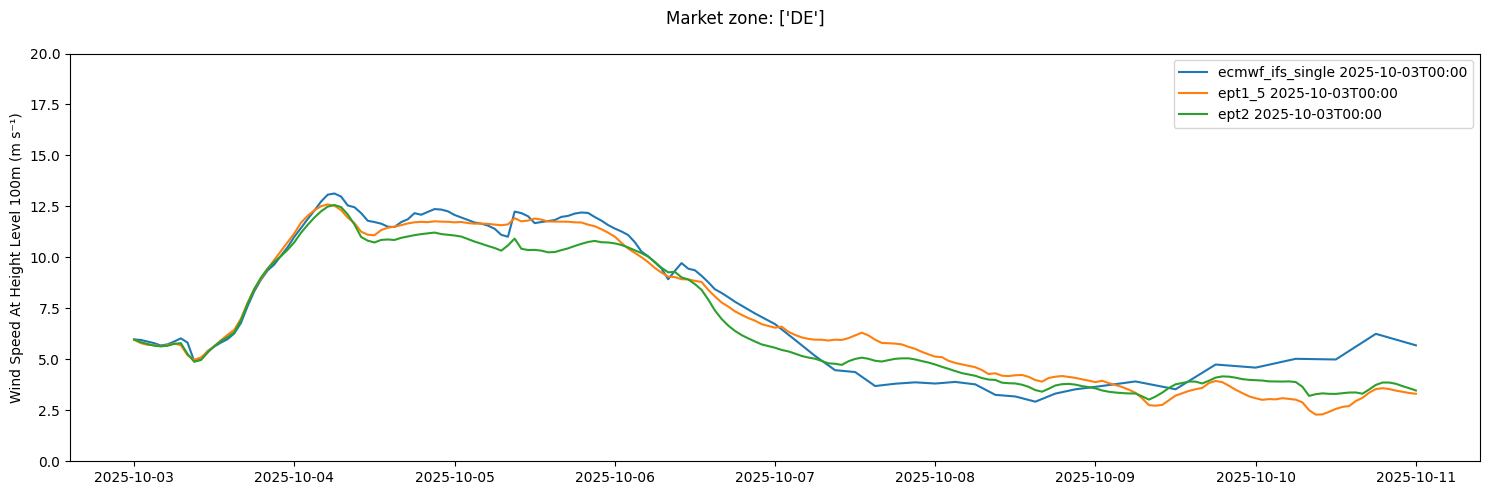

In [9]:
# Only keep runs for a selected init_time
ds_aggregates_2025_10_03_00 = ds_aggregates.where(
    ds_aggregates.init_time == np.datetime64("2025-10-03 00:00"),
    drop=True,
)

plot_market_aggregates(ds_aggregates_2025_10_03_00, ylim=(0, 20))

### Using Specific Forecast Runs

Instead of using the latest forecast to compute market aggregates, you can also specify the datetime for your run directly. Here we do so for population-weighted temperature:

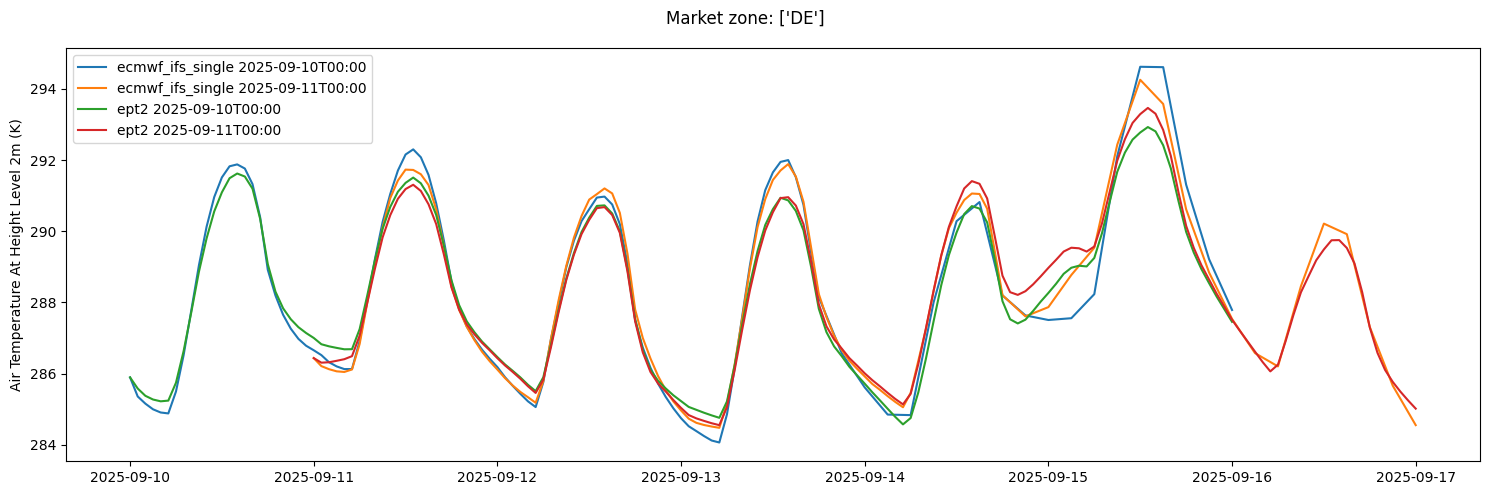

Returned Dataset:


<xarray.Dataset> Size: 12kB
Dimensions:                             (model_run: 4, time: 169)
Coordinates:
  * model_run                           (model_run) object 32B 'ecmwf_ifs_sin...
  * time                                (time) datetime64[ns, UTC] 1kB 2025-0...
    model                               (model_run) object 32B 'ecmwf_ifs_sin...
    init_time                           (model_run) datetime64[ns] 32B 2025-0...
Data variables:
    prediction_timedelta                (model_run, time) float64 5kB 0.0 ......
    air_temperature_at_height_level_2m  (model_run, time) float64 5kB 285.9 ....
Attributes:
    var_name:          air_temperature_at_height_level_2m
    var_display_name:  Air Temperature At Height Level 2m
    unit:              K
    weighting:         population
    market_zone:       ['DE']
    min_lead_time:     0
    max_lead_time:     144

In [10]:
ds_past_data = market_de.compare_runs(
    agg_variable=AggregateVariables.AIR_TEMPERATURE_AT_HEIGHT_LEVEL_2M,
    model_runs=[
        ModelRuns(Models.EPT2, [datetime(2025, 9, 10, 0), datetime(2025, 9, 11, 0)]),
        ModelRuns(
            Models.ECMWF_IFS_SINGLE,
            [datetime(2025, 9, 10, 0), datetime(2025, 9, 11, 0)],
        ),
    ],
    max_lead_time=6 * 24,
)

plot_market_aggregates(ds_past_data)

print("Returned Dataset:")
ds_past_data

### Combining Market Zones

You can also select multiple market zones to aggregate. In this example, we aggregate the market zones for Ireland and Northern Ireland.

In [11]:
# Create the market
market_ir_nir = client.market_aggregates.get_market(
    [MarketZones.IE, MarketZones.GB_NIR]
)
market_ir_nir

<EnergyMarket zones=['IE', 'GB-NIR']>

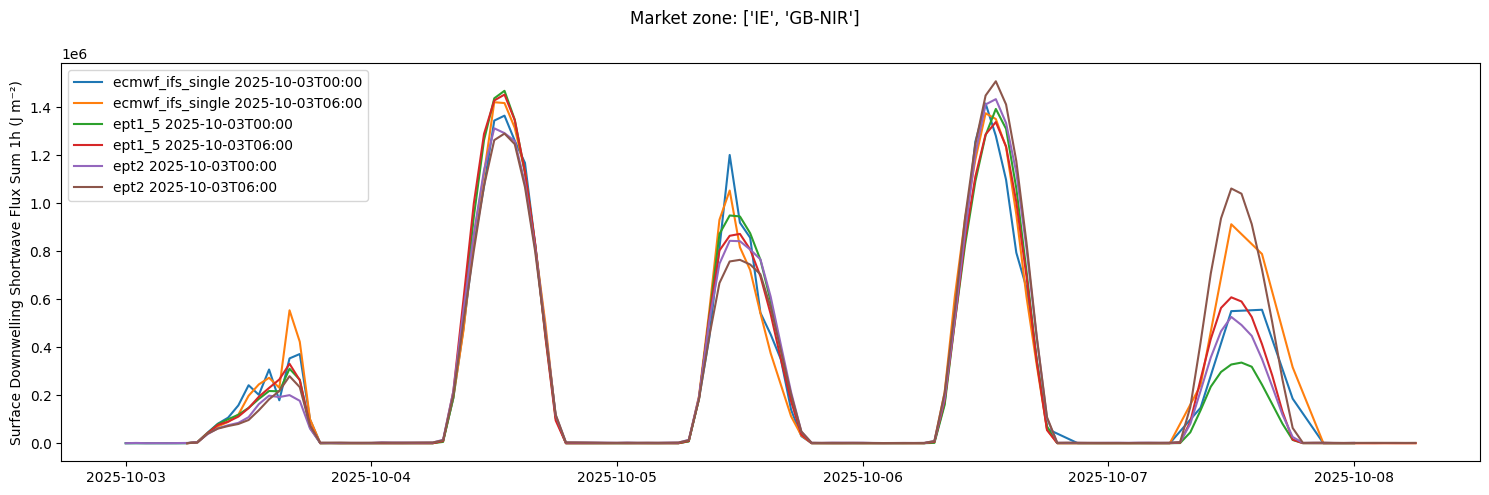

Returned Dataset:


<xarray.Dataset> Size: 13kB
Dimensions:                                    (model_run: 6, time: 127)
Coordinates:
  * model_run                                  (model_run) object 48B 'ecmwf_...
  * time                                       (time) datetime64[ns, UTC] 1kB ...
    model                                      (model_run) object 48B 'ecmwf_...
    init_time                                  (model_run) datetime64[ns] 48B ...
Data variables:
    prediction_timedelta                       (model_run, time) float64 6kB ...
    surface_downwelling_shortwave_flux_sum_1h  (model_run, time) float64 6kB ...
Attributes:
    var_name:          surface_downwelling_shortwave_flux_sum_1h
    var_display_name:  Surface Downwelling Shortwave Flux Sum 1h
    unit:              J m⁻²
    weighting:         solar_capacity
    market_zone:       ['IE', 'GB-NIR']
    min_lead_time:     0
    max_lead_time:     120

In [ ]:
# Select the model runs - here using the latest 2 runs for EPT 2, EPT 1.5 and ECMWF IFS
model_runs = [
    ModelRuns(Models.EPT2, [0, 1]),
    ModelRuns(Models.EPT1_5, [0, 1]),
    ModelRuns(Models.ECMWF_IFS_SINGLE, [0, 1]),
]

# Get the market aggregates for the next 5 days
ds_ir_nir = market_ir_nir.compare_runs(
    agg_variable=AggregateVariables.SURFACE_DOWNWELLING_SHORTWAVE_FLUX_SUM_1H,
    model_runs=model_runs,
    max_lead_time=5 * 24,
)

plot_market_aggregates(ds_ir_nir)

print("Returned Dataset:")
ds_ir_nir